In [ ]:
training_data_directory = 'train'
test_data_directory = 'test'

### Setup

Import the following Python modules. Remember to use ```pip``` to install any packages you are missing. For example, if you get an error: ```ModuleNotFoundError: No module named 'cv2'```, add a new cell by clicking the "+" button above and run the following command in another cell: ```!pip install opencv-python```.

In [ ]:
import os
import random
import re
import cv2
import time
import shutil
import zipfile
import urllib.request
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
from random import randrange
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

### Data

The data is separated into directories test and train. The test folder and train folder contain subdirectories corresponding to the possible soils. The labeled tree structure of the folders assists with marking the photos for training and testing.

In [ ]:
# download soil_photos.zip
file = 'soil_photos.zip'
url = 'http://apmonitor.com/pds/uploads/Main/'+file
urllib.request.urlretrieve(url, file)

# extract archive and remove soil_photos.zip
with zipfile.ZipFile(file, 'r') as zip_ref:
    zip_ref.extractall('./')
os.remove(file)

Import the data into the Python session. The first step is to process the images into a format that 1) makes the data readable to the model, and 2) provides more training material for the model to learn from. For example, the ```training_data_processor``` variable scales the data so that it can be a model input, but also takes each image and augments it so that the model can learn from multiple variations of the same picture. It flips it horizontally, rotates it, shifts it, and more so that the model learns from the soil photo rather than the orientation or size.

In [ ]:
# Initiate data processing tools
training_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)

test_data_processor = ImageDataGenerator(rescale = 1./255)

# Load data into Python
training_data = training_data_processor.flow_from_directory(
    training_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256 ,256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 75 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


### Model Building

Build the CNN model. The following cell sets parameters for model building. This includes the number of convolutional layers, fully connected dense layers, the number of nodes in each layer, and the number of training epochs. For more information on these parameters and Convolutional Neural Networks in general. The `layer_size` parameter has a large influence on the training speed, accuracy, and size of the model.

In [ ]:
# choose model parameters
num_conv_layers = 2
num_dense_layers = 1
layer_size = 32
num_training_epochs = 20
MODEL_NAME = 'soil'

In [ ]:
# Initiate model variable
model = Sequential()

# begin adding properties to model variable
# e.g. add a convolutional layer
model.add(Conv2D(layer_size, (3, 3), input_shape=(256,256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# add output layer
model.add(Dense(3))
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'],
                )

# use the data already loaded previously to train/tune the model
model.fit(training_data,
            epochs=num_training_epochs,
            validation_data = testing_data)

# save the trained model
model.save(f'{MODEL_NAME}.h5')

Epoch 1/20
3/3 [==============================] - 10s 2s/step - loss: 4.6445 - accuracy: 0.2400 - val_loss: 3.3133 - val_accuracy: 0.3333
Epoch 2/20
3/3 [==============================] - 7s 2s/step - loss: 2.2689 - accuracy: 0.3467 - val_loss: 3.0612 - val_accuracy: 0.3333
Epoch 3/20
3/3 [==============================] - 7s 2s/step - loss: 1.9981 - accuracy: 0.3333 - val_loss: 1.1515 - val_accuracy: 0.4000
Epoch 4/20
3/3 [==============================] - 8s 2s/step - loss: 1.0822 - accuracy: 0.5600 - val_loss: 1.3207 - val_accuracy: 0.3333
Epoch 5/20
3/3 [==============================] - 7s 2s/step - loss: 1.0302 - accuracy: 0.4133 - val_loss: 1.0209 - val_accuracy: 0.4000
Epoch 6/20
3/3 [==============================] - 7s 2s/step - loss: 0.9212 - accuracy: 0.6667 - val_loss: 0.9259 - val_accuracy: 0.4667
Epoch 7/20
3/3 [==============================] - 8s 2s/step - loss: 0.8897 - accuracy: 0.6267 - val_loss: 1.0366 - val_accuracy: 0.5333
Epoch 8/20
3/3 [========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model Testing

The model has now been trained and has been saved to the computer (in the same folder as this notebook). The last line of the printed output above contains the accuracy for both the training data and the validation, or testing data. Pay attention to the ```val_accuracy``` value on the last line, which corresponds to the accuracy on images that the model was not trained on. This is the best measure of the estimator performance on other images.

The following function, ```make_prediction```, takes the file path to a soil photo as an input and outputs the classification that the model predicted. From the test folder, copy the filepath into the test_image_filepath variable in the second cell. Try out a few photos and see how the model preforms.

In [ ]:
def make_prediction(image_fp):
    im = cv2.imread(image_fp) # load image
    plt.imshow(im[:,:,[2,1,0]])
    img = image.load_img(image_fp, target_size = (256,256))
    img = image.img_to_array(img)

    image_array = img / 255. # scale the image
    img_batch = np.expand_dims(image_array, axis = 0)

    class_ = ["Gravel", "Sand", "Silt"] # possible output values
    predicted_value = class_[model.predict(img_batch).argmax()]
    true_value = re.search(r'(Gravel)|(Sand)|(Silt)', image_fp)[0]

    out = f"""Predicted Soil Type: {predicted_value}
    True Soil Type: {true_value}
    Correct?: {predicted_value == true_value}"""

    return out

1/1 [==============================] - 0s 154ms/step
Predicted Soil Type: Sand
    True Soil Type: Sand
    Correct?: True


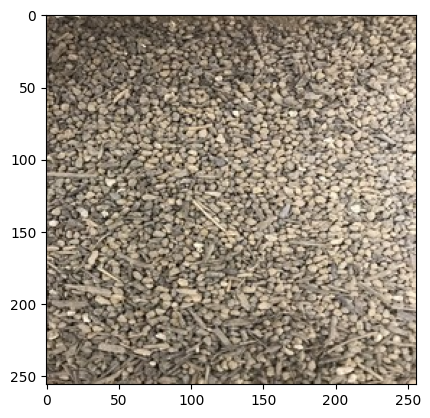

In [ ]:
test_image_filepath = test_data_directory + r'/Sand/0.jpg'
print(make_prediction(test_image_filepath))

### Soil Classification Percentages

Soils are not perfectly homogenous (all one soil type). Soils are often a blend of types and may be better represented using a percentage. For example, the cell below shows a test photo that is labeled "Silt":

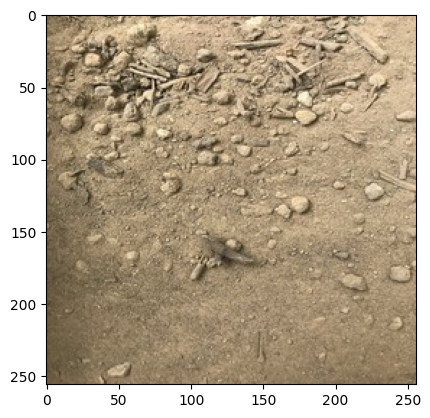

In [ ]:
percentage_photo = test_data_directory + r"/Silt/5.jpg"
im = cv2.imread(percentage_photo) # load image
plt.imshow(im[:,:,[2,1,0]])

This photo has some gravel, however, there appears to be sand, gravel, and silt all in one photo. In order to better classify this image, create a proportion of each label. For example, this photo might be 30% Gravel, 20% Sand, and 50% Silt.

Subdivide the photo into many smaller segments or squares and train a classifier on the smaller squares. Loop through the photo  to classify each small square and take a proportion of the squares pertaining to Gravel, Sand, and Silt. This proportion is then converted into a percentage of the respective soil type.

### Data

Run these cells below to subdivide the existing training photos into smaller segments. The new directory will be called train_divided and test_divided.  

In [ ]:
def split_images(image_dir, save_dir):
    classification_list = ['Gravel', 'Sand', 'Silt']
    for classification in classification_list:
        folder = image_dir + '/' + classification + '/'
        save_folder = save_dir + '/' + classification + '/'
        files = [f for f in listdir(folder) if isfile(join(folder, f))]

        for file in files:
            if '.ini' in file:
                continue
            fp = folder + file
            img = cv2.imread(fp)
            h,w,c = img.shape
            im_dim = 64
            # For cropping images
            for r in range(0,img.shape[0],im_dim):
                for c in range(0,img.shape[1],im_dim):
                    cropped_img = img[r:r+im_dim, c:c+im_dim,:]
                    ch, cw, cc = cropped_img.shape
                    if ch == im_dim and cw == im_dim:
                        write_path = f"{save_folder + str(randrange(100000))}img{r}_{c}.jpg"
                        cv2.imwrite(write_path,cropped_img)
                    else:
                        pass

In [ ]:
try:
    parent = training_data_directory.replace('train', '')
    dirs = ['train_divided', 'test_divided']
    class_ = ["Gravel", "Sand", "Silt"]
    for dir in dirs:
        os.mkdir(os.path.join(parent, dir))
        for classification in class_:
            os.mkdir(os.path.join(parent, dir, classification))

    # split training images
    split_images(image_dir=training_data_directory,
                save_dir=training_data_directory.replace('train', 'train_divided'))
    # split test images
    split_images(image_dir=test_data_directory,
                save_dir=test_data_directory.replace('test', 'test_divided'))
except FileExistsError:
    pass

### Load Model

If the number of input pixels changes, a new model should be trained or the image rescaled to the original training dimensions. For the purposes of this demo, retraining is not needed because the photos are upscaled to 1024x1024 before subsampling 256x256 blocks (16) in each image.

In [ ]:
model_fp = os.getcwd()+'/'+'soil.h5'
print(model_fp)
model = load_model(model_fp)

/content/soil.h5


### Classify Image

Use the loaded model to classify a test image. The function `classify_images` takes an image and a model and loops through each 256x256 square. It classifies each square and adds to the counter to create the fractional soil prediction. The function outputs the proportion of each soil type that was classified.

In [ ]:
def classify_images(image_fp, model):
    classes = ['Gravel', 'Sand', 'Silt']
    gravel_count = 0
    sand_count = 0
    silt_count = 0

    img = cv2.imread(image_fp)
    img = cv2.resize(img,(1024,1024))
    im_dim = 256

    for r in range(0, img.shape[0], im_dim):
        for c in range(0, img.shape[1], im_dim):
            cropped_img = img[r:r + im_dim, c:c + im_dim, :]
            h, w, c = cropped_img.shape
            if h == im_dim and w == im_dim:
                classification = model_classify(cropped_img, model)
                if classification == classes[0]:
                    gravel_count += 1
                elif classification == classes[1]:
                    sand_count += 1
                elif classification == classes[2]:
                    silt_count += 1
            else:
                continue
    total_count = gravel_count + sand_count + silt_count
    proportion_array = [gravel_count / total_count, sand_count / total_count, silt_count / total_count]
    return proportion_array


def model_classify(cropped_img, model):
    classes = ['Gravel', 'Sand', 'Silt']
    image_array = cropped_img / 255.
    img_batch = np.expand_dims(image_array, axis=0)
    prediction_array = model.predict(img_batch)[0]
    first_idx = np.argmax(prediction_array)
    first_class = classes[first_idx]
    return first_class

def classify_percentage(image_fp):
    start = time.time()
    out = classify_images(image_fp=image_fp, model=model)
    finish = str(round(time.time() - start, 5))

    im = cv2.imread(image_fp) # load image
    plt.imshow(im[:,:,[2, 1, 0]])

    print(f'''---
Percent Gravel: {round(out[0] * 100, 2)}%)
Percent Sand: {round(out[1] * 100, 2)}%)
Percent Silt: {round(out[2] * 100, 2)}%)
Time to Classify: {finish} seconds
---''')

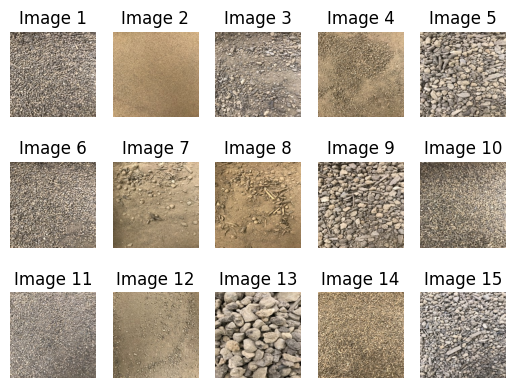

In [ ]:

test_image_folder = 'test'
test_image_paths = [join(test_image_folder, class_folder, f) for class_folder in listdir(test_image_folder) for f in listdir(join(test_image_folder, class_folder))]
selected_images = random.sample(test_image_paths, 15)

for i, image_path in enumerate(selected_images):
    im = cv2.imread(image_path)
    plt.subplot(3, 5, i + 1)
    plt.imshow(im[:, :, [2, 1, 0]])
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.show()


Choose an image (1-15): 14
1/1 [==============================] - 0s 94ms/step
---
Percent Gravel: 100.0%)
Percent Sand: 0.0%)
Percent Silt: 0.0%)
Time to Classify: 1.7944 seconds
---


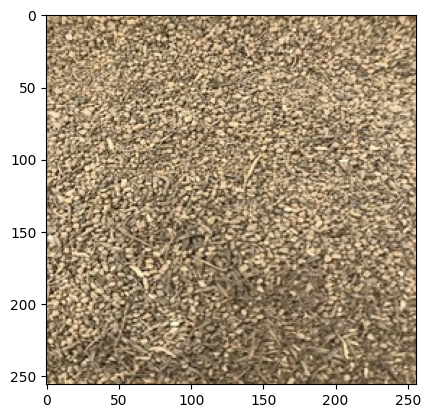

In [ ]:
chosen_image_index = int(input("Choose an image (1-15): ")) - 1
chosen_image_path = selected_images[chosen_image_index]
classify_percentage(image_fp=chosen_image_path)